![CTA first data challenge logo](images/cta-1dc.png)

# CTA data analysis with Gammapy

## Introduction

**This notebook shows an example how to make a sky image and spectrum for simulated CTA data with Gammapy.**

The dataset we will use is three observation runs on the Galactic center. This is a tiny (and thus quick to process and play with and learn) subset of the simulated CTA dataset that was produced for the first data challenge in August 2017.

**This notebook can be considered part 2 of the introduction to CTA 1DC analysis. Part one is here: [cta_1dc_introduction.ipynb](cta_1dc_introduction.ipynb)**

## Setup

As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
!gammapy info --no-envvar --no-system


Gammapy package:

	path                   : /home/hfm/adonath/github/adonath/gammapy/gammapy 
	version                : 0.8.dev7296 
	githash                : 2b363a5f196b9055e99cd31ecd0dcde5dab217f9 


Other packages:

	numpy                  : 1.16.0.dev0+65f15a5 
	scipy                  : 1.1.0      
	matplotlib             : 2.1.1      
	cython                 : 0.28.5     
	astropy                : 3.0.4      
	astropy_healpix        : 0.2        
	reproject              : 0.4        
	sherpa                 : 4.10.0     
	pytest                 : 3.7.2      
	sphinx                 : 1.7.5      
	healpy                 : 1.12.3     
	regions                : 0.3        
	iminuit                : 1.2        
	naima                  : not installed 
	uncertainties          : 3.0.2      



In [3]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion
from gammapy.utils.energy import EnergyBounds
from gammapy.data import DataStore
from gammapy.spectrum import (
    SpectrumExtraction,
    SpectrumFit,
    SpectrumResult,
    models,
    SpectrumEnergyGroupMaker,
    FluxPointEstimator,
)
from gammapy.maps import Map, MapAxis, WcsNDMap, WcsGeom
from gammapy.cube import MapMaker
from gammapy.background import ReflectedRegionsBackgroundEstimator
from gammapy.detect import TSMapEstimator, find_peaks

In [4]:
# Configure the logger, so that the spectral analysis
# isn't so chatty about what it's doing.
import logging

logging.basicConfig()
log = logging.getLogger("gammapy.spectrum")
log.setLevel(logging.ERROR)

## Select observations

Like explained in [cta_1dc_introduction.ipynb](cta_1dc_introduction.ipynb), a Gammapy analysis usually starts by creating a `DataStore` and selecting observations.

This is shown in detail in the other notebook, here we just pick three observations near the galactic center.

In [5]:
# data_store = DataStore.from_dir('$CTADATA/index/gps')
data_store = DataStore.from_dir("$GAMMAPY_EXTRA/datasets/cta-1dc/index/gps/")

In [6]:
# Just as a reminder: this is how to select observations
# from astropy.coordinates import SkyCoord
# table = data_store.obs_table
# pos_obs = SkyCoord(table['GLON_PNT'], table['GLAT_PNT'], frame='galactic', unit='deg')
# pos_target = SkyCoord(0, 0, frame='galactic', unit='deg')
# offset = pos_target.separation(pos_obs).deg
# mask = (1 < offset) & (offset < 2)
# table = table[mask]
# table.show_in_browser(jsviewer=True)

In [7]:
obs_id = [110380, 111140, 111159]
obs_list = data_store.obs_list(obs_id)

In [8]:
obs_cols = ["OBS_ID", "GLON_PNT", "GLAT_PNT", "LIVETIME"]
data_store.obs_table.select_obs_id(obs_id)[obs_cols]

OBS_ID,GLON_PNT,GLAT_PNT,LIVETIME
int64,float64,float64,float64
110380,359.9999912037958,-1.2999959379053694,1764.0
111140,358.4999833830074,1.3000020211954266,1764.0
111159,1.5000056568267741,1.299940468335294,1764.0


## Make sky images

### Define map geometry

Select the target position and define an ON region for the spectral analysis

In [9]:
axis = MapAxis.from_edges(
    np.logspace(-1., 1., 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0), npix=(500, 400), binsz=0.02, coordsys="GAL", axes=[axis]
)
geom

WcsGeom

	axes       : lon, lat, energy
	shape      : (500, 400, 9)
	ndim       : 3
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 x 8.0 deg

### Compute images

Exclusion mask currently unused. Remove here or move to later in the tutorial?

In [10]:
target_position = SkyCoord(0, 0, unit="deg", frame="galactic")
on_radius = 0.2 * u.deg
on_region = CircleSkyRegion(center=target_position, radius=on_radius)

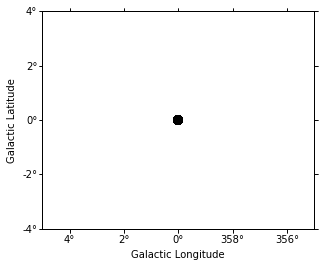

In [11]:
exclusion_mask = geom.to_image().region_mask([on_region], inside=False)
exclusion_mask = WcsNDMap(geom.to_image(), exclusion_mask)
exclusion_mask.plot();

In [12]:
%%time
maker = MapMaker(geom, offset_max="2 deg")
maps = maker.run(obs_list)
print(maps.keys())

dict_keys(['counts', 'exposure', 'background'])
CPU times: user 3.92 s, sys: 179 ms, total: 4.1 s
Wall time: 4.1 s


In [13]:
# The maps are cubes, with an energy axis.
# Let's also make some images:
images = maker.make_images()

excess = images["counts"].copy()
excess.data -= images["background"].data
images["excess"] = excess

### Show images

Let's have a quick look at the images we computed ...

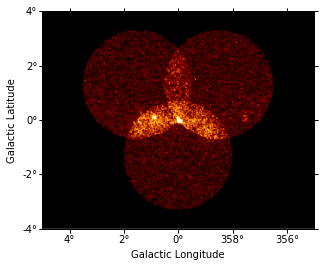

In [14]:
images["counts"].smooth(2).plot(vmax=5);

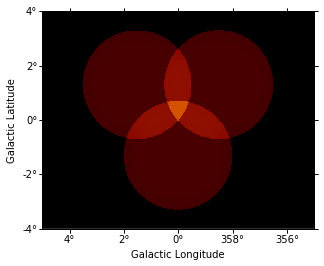

In [15]:
images["background"].plot(vmax=5);

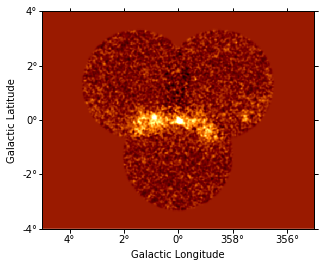

In [16]:
images["excess"].smooth(3).plot(vmax=2);

## Source Detection

Use the class [gammapy.detect.TSMapEstimator](http://docs.gammapy.org/dev/api/gammapy.detect.TSMapEstimator.html) and [gammapy.detect.find_peaks](http://docs.gammapy.org/dev/api/gammapy.detect.find_peaks.html) to detect sources on the images:

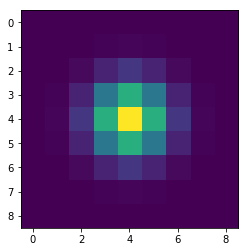

In [17]:
kernel = Gaussian2DKernel(1, mode="oversample").array
plt.imshow(kernel);

In [18]:
%%time
ts_image_estimator = TSMapEstimator()
images_ts = ts_image_estimator.run(images, kernel)
print(images_ts.keys())

dict_keys(['ts', 'sqrt_ts', 'flux', 'flux_err', 'flux_ul', 'niter'])
CPU times: user 1.3 s, sys: 80.3 ms, total: 1.38 s
Wall time: 13.9 s


In [19]:
sources = find_peaks(images_ts["sqrt_ts"], threshold=8)
sources

value,x,y,ra,dec
,,,deg,deg
float32,int64,int64,float64,float64
19.798,252,197,266.42400,-29.00490
8.9666,207,204,266.82019,-28.16314


In [20]:
source_pos = SkyCoord(sources["ra"], sources["dec"])
source_pos

<SkyCoord (ICRS): (ra, dec) in deg
    [(266.42399798, -29.00490483), (266.82018801, -28.16313964)]>

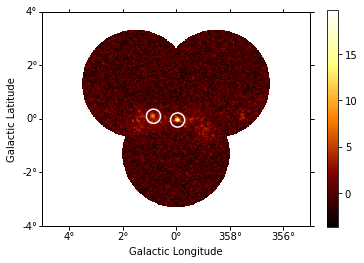

In [21]:
# Plot sources on top of significance sky image
images_ts["sqrt_ts"].plot(add_cbar=True)

plt.gca().scatter(
    source_pos.ra.deg,
    source_pos.dec.deg,
    transform=plt.gca().get_transform("icrs"),
    color="none",
    edgecolor="white",
    marker="o",
    s=200,
    lw=1.5,
);

## Spatial analysis

See other notebooks for how to run a 3D cube or 2D image based analysis.

## Spectrum

We'll run a spectral analysis using the classical reflected regions background estimation method,
and using the on-off (often called WSTAT) likelihood function.

### Extraction

The first step is to "extract" the spectrum, i.e. 1-dimensional counts and exposure and background vectors, as well as an energy dispersion matrix from the data and IRFs.

/home/hfm/adonath/Software/Applications/anaconda3.5/envs/gammapy-dev/lib/python3.6/site-packages/matplotlib/patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


CPU times: user 7.58 s, sys: 23.2 ms, total: 7.6 s
Wall time: 7.6 s


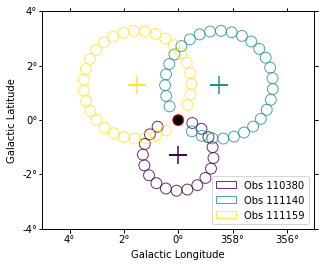

In [22]:
%%time
bkg_estimator = ReflectedRegionsBackgroundEstimator(
    obs_list=obs_list, on_region=on_region, exclusion_mask=exclusion_mask
)
bkg_estimator.run()
bkg_estimate = bkg_estimator.result
bkg_estimator.plot();

In [23]:
%%time
extract = SpectrumExtraction(obs_list=obs_list, bkg_estimate=bkg_estimate)
extract.run()
observations = extract.observations

CPU times: user 1.01 s, sys: 0 ns, total: 1.01 s
Wall time: 1.01 s


### Model fit

The next step is to fit a spectral model, using all data (i.e. a "global" fit, using all energies).

In [24]:
%%time
model = models.PowerLaw(
    index=2, amplitude=1e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)
fit = SpectrumFit(observations, model)
fit.run()
print(fit.result[0])


Fit result info 
--------------- 
Model: PowerLaw

Parameters: 

	   name     value     error         unit         min    max
	--------- --------- --------- --------------- --------- ---
	    index 2.225e+00 2.616e-02                       nan nan
	amplitude 3.013e-12 1.396e-13 1 / (cm2 s TeV)       nan nan
	reference 1.000e+00 0.000e+00             TeV 0.000e+00 nan

Covariance: 

	   name           index                amplitude        reference
	--------- ---------------------- ---------------------- ---------
	    index  0.0006841652825656269 -9.885186713191302e-16       0.0
	amplitude -9.885186713191302e-16  1.950116783626623e-26       0.0
	reference                    0.0                    0.0       0.0 

Statistic: 91.148 (wstat)
Fit Range: [1.e-02 1.e+02] TeV

CPU times: user 1.91 s, sys: 128 ms, total: 2.04 s
Wall time: 543 ms


### Spectral points

Finally, let's compute spectral points. The method used is to first choose an energy binning, and then to do a 1-dim likelihood fit / profile to compute the flux and flux error.

In [25]:
# Flux points are computed on stacked observation
stacked_obs = extract.observations.stack()
print(stacked_obs)

*** Observation summary report ***
Observation Id: [110380-111159]
Livetime: 1.470 h
On events: 2377
Off events: 34876
Alpha: 0.041
Bkg events in On region: 1435.66
Excess: 941.34
Excess / Background: 0.66
Gamma rate: 0.18 1 / s
Bkg rate: 0.23 1 / min
Sigma: 22.14
energy range: 0.01 TeV - 100.00 TeV


In [26]:
ebounds = EnergyBounds.equal_log_spacing(1, 40, 4, unit=u.TeV)

seg = SpectrumEnergyGroupMaker(obs=stacked_obs)
seg.compute_groups_fixed(ebounds=ebounds)

fpe = FluxPointEstimator(
    obs=stacked_obs, groups=seg.groups, model=fit.result[0].model
)
fpe.compute_points()
fpe.flux_points.table

e_ref,e_min,e_max,dnde,dnde_err,dnde_ul,is_ul,sqrt_ts,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,bool,float64,float64,float64
1.56474814165802,1.0,2.448436746822227,1.0966592708668344e-12,1.234115771176153e-13,1.358492496486616e-12,False,13.858482223414244,nan,nan
3.831186849557287,2.448436746822227,5.994842503189409,1.5724300672233357e-13,1.9436004978747327e-14,1.9848630622707861e-13,False,13.709159218592966,nan,nan
9.999999999999995,5.994842503189409,16.681005372000573,1.1900501193982599e-14,2.6277413699386e-15,1.786436557500502e-14,False,7.465622919771905,nan,nan
26.101572156825345,16.681005372000573,40.84238652674517,7.470699703157546e-16,4.1435828053394485e-16,1.8347446929787114e-15,False,2.755707476665549,nan,nan


### Plot

Let's plot the spectral model and points. You could do it directly, but there is a helper class.
Note that a spectral uncertainty band, a "butterfly" is drawn, but it is very thin, i.e. barely visible.

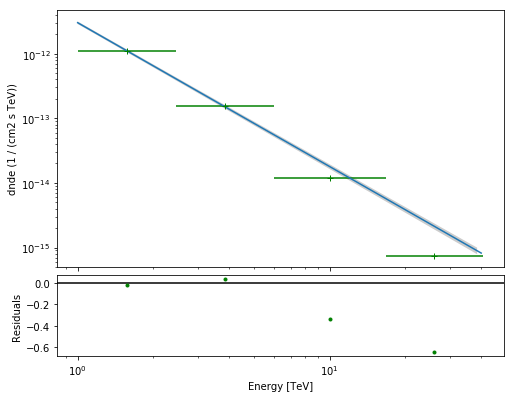

In [27]:
total_result = SpectrumResult(
    model=fit.result[0].model, points=fpe.flux_points
)

total_result.plot(
    energy_range=[1, 40] * u.TeV,
    fig_kwargs=dict(figsize=(8, 8)),
    point_kwargs=dict(color="green"),
);

## Exercises

* Re-run the analysis above, varying some analysis parameters, e.g.
    * Select a few other observations
    * Change the energy band for the map
    * Change the spectral model for the fit
    * Change the energy binning for the spectral points
* Change the target. Make a sky image and spectrum for your favourite source.
    * If you don't know any, the Crab nebula is the "hello world!" analysis of gamma-ray astronomy.

In [28]:
# print('hello world')
# SkyCoord.from_name('crab')

## What next?

* This notebook showed an example of a first CTA analysis with Gammapy, using simulated 1DC data.
* This was part 2 for CTA 1DC turorial, the first part was here: [cta_1dc_introduction.ipynb](cta_1dc_introduction.ipynb)
* More tutorials (not 1DC or CTA specific) with Gammapy are [here](../index.ipynb)
* Let us know if you have any question or issues!